# EDA
## Analizando columnas


In [ ]:
%load_ext autoreload
%autoreload 2

In [112]:
import os
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
plt.style.use('ggplot')
%matplotlib inline

In [ ]:
from src.data.location_notebook import get_location

In [ ]:
(DATA_DIR, DATA_DIR_PROCESSED, 
INTERMEDIATE_RESULTS, GROUP_INTERMEDIATE_RESULTS, 
CLEANED_DS , TRAIN_RAW_FILE, 
VALIDATION_RAW_FILE, TEMPLATE_SUBMIT) = get_location()

In [ ]:
date_columns = [
    "Account_Created_Date", 
    "Opportunity_Created_Date",
    "Last_Activity",
    "Quote_Expiry_Date",
    "Last_Modified_Date",
    "Planned_Delivery_Start_Date",
    "Planned_Delivery_End_Date",
    "Actual_Delivery_Date"
]

df_train = pd.read_csv(os.path.join(DATA_DIR, TRAIN_RAW_FILE), parse_dates=date_columns, na_values=["None"])
df_val = pd.read_csv(os.path.join(DATA_DIR, VALIDATION_RAW_FILE), parse_dates=date_columns, na_values=["None"])

template_submit = pd.read_csv(os.path.join(DATA_DIR, TEMPLATE_SUBMIT))

In [ ]:
df_train.loc[:, ~df_train.columns.isin(df_val.columns)].columns

In [ ]:
df_val.loc[:, ~df_val.columns.isin(df_train.columns)].columns

Tiene sentido que la única columna que falte, es la columna que tenemos que predecir, nuestro target, "Stage"

In [ ]:
print("Tamaño Train: {}, Tamaño Validation: {}, Tamaño Submit-Ejemplo: {}".format(len(df_train), len(df_val), len(template_submit)))

In [ ]:
print("Oportunidades Train: {}, Oportunidades Validation: {}".format(df_train.Opportunity_ID.nunique(), df_val.Opportunity_ID.nunique()))

## Analisis Exploratorio General

In [ ]:
df_train.describe()

In [ ]:
df_train.info()

profile = ProfileReport(df_train, title='Reporte', explorative=True, minimal=True)
profile2 = ProfileReport(df_val, title='Reporte Validacion', explorative=True, minimal=True)

La siguiente linea tarda mucho tiempo

In [ ]:
# _ = profile.to_file("../reports/reporte_train.html")
# _ = profile2.to_file("../reports/reporte_valid.html")

En análisis simple se describe en el reporte, acá se ven relaciones entre features o consultas más complejas.

### Products

Q: Cuantos products hay?
A: 506

In [ ]:
df_train.Product_Name.nunique(), df_val.Product_Name.nunique(), df_train.Product_Name.append(df_val.Product_Name).nunique()

Q: Cuantos products hay en validación que también están en training?
A: 141

In [ ]:
df_train.Product_Name.append(df_val.Product_Name).nunique(), 456+191-506, 506 - 141

Si en realidad hacemos one-hot de todos los productos, tendremos aproximadamente 141 columnas sin completar en train, pero 365 en validación. 

### Opportunity_Owner
Q: Cuentas por Owner? 

In [ ]:
df_train[["Opportunity_Owner", "Account_Name"]].groupby('Opportunity_Owner').count().sort_values(ascending=False, by='Account_Name')

Q: Cuantas oportunidades por Owner?
A: NOTA: los ejes no son los mismos

In [ ]:
df_train.groupby('Opportunity_Owner').Opportunity_ID.nunique().sort_values(ascending=False).head(10).plot.barh()

In [ ]:
df_train.groupby('Opportunity_Owner').Opportunity_ID.nunique().sort_values(ascending=True).head(10).plot.barh()

Q: Owners en validación que no están en training?
A: Solo hay 5, es decir son todos nuevos.

In [ ]:
df_train.Opportunity_Owner.nunique(), df_val.Opportunity_Owner.nunique()

In [ ]:
df_train.Opportunity_Owner.append(df_val.Opportunity_Owner).nunique()

In [ ]:
53+35-58

### Acum_Total_Amount - Total_Taxable_Amount
Descripción: Acumulamos el total POR oportunidad y descontamos el impuesto. 

In [57]:
rel = df_train[["Opportunity_ID", "Total_Amount", "Total_Taxable_Amount"]].groupby("Opportunity_ID").agg({'Total_Amount':'sum', 'Total_Taxable_Amount': "mean"})
rel["diferencia"] = rel.Total_Amount - rel.Total_Taxable_Amount

Q: Cuantas Opportunidades tienen diferencia > 0 y al menos tiene impuesto.? 
A: 75

In [59]:
rel[((rel.Total_Amount != rel.diferencia) & (rel.diferencia > 0))]

,Total_Amount,Total_Taxable_Amount,diferencia
Opportunity_ID,,,
417,1678696.43,1.678696e+06,2.328306e-10
553,10065653.85,1.006565e+07,1.862645e-09
767,10307538.56,1.030754e+07,1.862645e-09
801,10057887.60,5.841002e+06,4.216886e+06
1510,902211.70,4.367117e+05,4.655000e+05
...,...,...,...
12634,56953530.90,5.695353e+07,1.490116e-08
12651,3663431.25,3.238840e+06,4.245917e+05
12745,305235.00,2.698583e+05,3.537674e+04


Q: Cuantas oportunidades tienen impuesto igual al amount?
A: 9052

In [62]:
rel[(rel.diferencia == 0)]

,Total_Amount,Total_Taxable_Amount,diferencia
Opportunity_ID,,,
0,5272800.00,5272800.00,0.0
1,48230.00,48230.00,0.0
2,83865.60,83865.60,0.0
3,7421881.50,7421881.50,0.0
4,13357192.50,13357192.50,0.0
...,...,...,...
12797,528918.75,528918.75,0.0
12798,1307775.00,1307775.00,0.0
12799,401700.00,401700.00,0.0


### Target: Stage
- La variable Stage está un poco desbalanceada a los casos positivos (Close Won). 
- Hay más variables que deberíamos reagrupar en una nueva categoría.
- Podríamos agrugar en categoría "Close Won", "Closed Lost" y "Otros"
    - según la máquina de estados las otras oportunidades no son Closed Lost

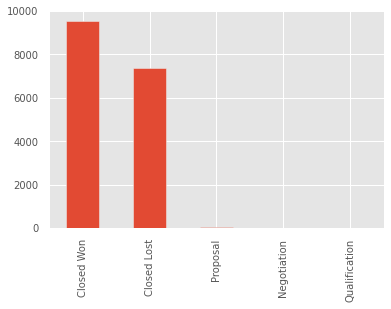

In [63]:
df_train.Stage.value_counts().plot.bar()

Cargamos el dataset ya curado en la notebook 01.

In [64]:
df = pd.read_parquet(INTERMEDIATE_RESULTS)
df_train = df_train.merge(df, on="Opportunity_ID", how='left', suffixes=("_x", ""))

In [65]:
cols_drop = df_train.columns[df_train.columns.str.contains("_x")]
df_train = df_train.loc[:, ~df_train.columns.isin(cols_drop)]

Tratamos a stage como una serie temporal. Como va evolucionando en general por mes-año.

In [87]:
ts = df_train.groupby(df_train.Opportunity_Created_Date.dt.year*100 + df_train.Opportunity_Created_Date.dt.month).Stage.value_counts().to_frame()
ts.columns = ["Count"]
ts = ts.reset_index()
ts = ts.pivot(index="Opportunity_Created_Date", columns='Stage', values='Count')[["Closed Lost", "Closed Won"]]
ts.index  = pd.to_datetime(ts.reset_index().Opportunity_Created_Date, format='%Y%m')
ts

Stage,Closed Lost,Closed Won
Opportunity_Created_Date,,
2013-11-01,1.0,NaN
2014-03-01,5.0,NaN
2014-05-01,1.0,4.0
2014-06-01,NaN,4.0
2014-07-01,2.0,NaN
2014-08-01,NaN,2.0
2014-09-01,41.0,NaN
2014-10-01,6.0,1.0
2014-12-01,2.0,68.0


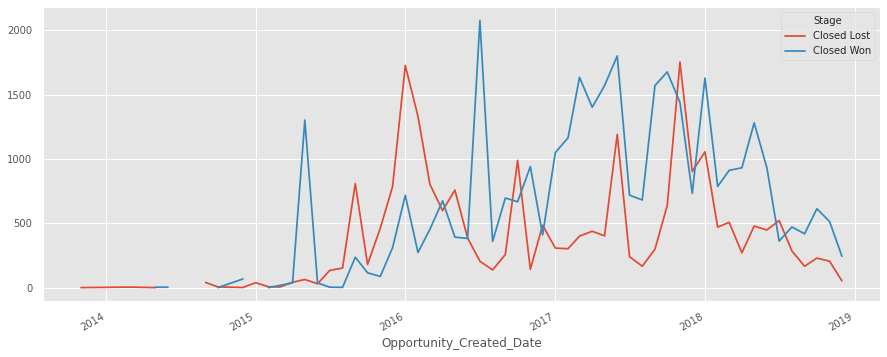

In [91]:
ts.plot.line(figsize=(15,6))

Comparamos las oportunidades 2017 y 2018 entre regiones.

In [97]:
d = df_train[df_train.Opportunity_Created_Date.dt.year >= 2017]\
    .groupby(['Region', df_train.Opportunity_Created_Date.dt.year*100+df_train.Opportunity_Created_Date.dt.month, "Stage"])\
    .Opportunity_ID\
    .nunique().to_frame()\
    .reset_index()

In [98]:
d['Opportunity_Created_Date'] = pd.to_datetime(d.reset_index().Opportunity_Created_Date, format='%Y%m')

Verificamos por contrato cual es la distribución de Stage
- sales_contract_no: # contrato, si no tiene va en nan. 
    - se confirmó en la competencia que esta columna es data-leakage. 
    - Al parecer, una persona que firma un contrato, cuando se adjudica un won
- quote_type: tipo de presupuesto (Categórica)

In [105]:
df_train.loc[:, 'has_contract'] = ~df_train.Sales_Contract_No.isna()

In [151]:
pd.crosstab(df_train.has_contract, df_train["Stage"],  margins = False)

Stage,Closed Lost,Closed Won,Negotiation,Proposal,Qualification
has_contract,,,,,
False,19987,274,18,35,11
True,2359,34555,0,0,0


- Se puede ver que la gran parte de los que tienen contratos, se cerraron ganadoras y las que no tienen contrato, se cerraron perdedoras. 
- La idea de los splits de arboles, es que las clases queden "homogeneas", así tenemos más ganancia de información. 

ver: [Ganancia de Información- PUCC](https://www.coursera.org/lecture/mineria-de-datos-introduccion/ganancia-de-informacion-zenxs)

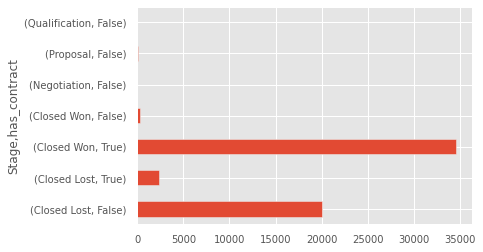

In [106]:
df_train.groupby('Stage').has_contract.value_counts().plot.barh()

In [110]:
df_train.groupby('Stage').Opportunity_ID.nunique()

In [122]:
def entropy(weight):
    size = weight.sum()
    e = (-weight/size * np.log2(weight/size)).sum()
    return e

In [127]:
closed_lost_size = 4719
closed_won_size = 5072
entropia_inicial = entropy(np.array([4719,5072]))
entropia_inicial

0.999062148713672

In [118]:
# calculamos entropia al dividir por has_contract
df_train[df_train.has_contract==True].groupby('Stage').Opportunity_ID.nunique()

Stage
Closed Lost     295
Closed Won     4971
Name: Opportunity_ID, dtype: int64

In [123]:
df_train[df_train.has_contract==False].groupby('Stage').Opportunity_ID.nunique()

Stage
Closed Lost      4424
Closed Won        101
Negotiation        11
Proposal           30
Qualification       9
Name: Opportunity_ID, dtype: int64

In [125]:
entropia_true = entropy(np.array([295,4971]))
entropia_false = entropy(np.array([4424,101]))
entropia_true, entropia_false

In [130]:
# information gain = entropia inicial - sum x split * entropia_split
entropia_inicial - ( (4424+101)/(4719+5072) * entropia_false) -  ( (295+4917)/(4719+5072) * entropia_true)

# hay que elegir la que tiene el information gain más alto. 

0.7619747823911445

Revisamos Quote_Type para ver si es un buen indicador para realizar split.

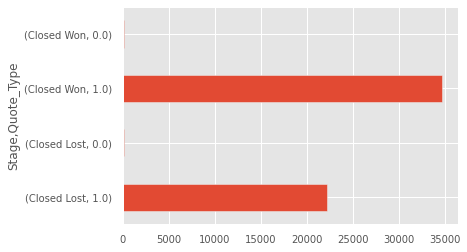

In [139]:
df_train.groupby('Stage').Quote_Type.value_counts().plot.barh()

In [140]:
df_train[['Stage', "Opportunity_ID","Quote_Type"]].drop_duplicates().groupby(['Stage']).Quote_Type.value_counts()

Stage        Quote_Type
Closed Lost  1.0           4650
             0.0             66
Closed Won   1.0           5007
             0.0             64
Name: Quote_Type, dtype: int64

In [141]:
entropia_q_1 = entropy(np.array([4650,5007]))
entropia_q_0 = entropy(np.array([66,64]))
entropia_inicial - ( (4650+5007)/(4719+5072) * entropia_q_1) -  ( (66+64)/(4719+5072) * entropia_q_0)
# esta variable no es un buen indicador.

0.00044550129604290986